## Final Project Submission

Please fill out:
* Student name: Jasper Chen
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import sqlite3
from pandasql import sqldf
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())

conn = sqlite3.connect('zippeddata/im.db')


In [2]:
q = '''
SELECT * FROM movie_basics AS mb
JOIN movie_ratings AS mr ON mr.movie_id = mb.movie_id
WHERE start_year >= 2012
'''

moviesdf = pd.read_sql(q, conn)
moviesdf.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119


In [3]:
bomdf = pd.read_csv('zippeddata/bom.movie_gross.csv.gz')
bomdf

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [4]:
# Clean data
budgetsdf = pd.read_csv("zippeddata/tn.movie_budgets.csv.gz")
budgetsdf['worldwide_gross'] = budgetsdf['worldwide_gross'].replace('[$,]', '', regex=True).astype(float)
budgetsdf['domestic_gross'] = budgetsdf['domestic_gross'].replace('[$,]', '', regex=True).astype(float)
budgetsdf['production_budget'] = budgetsdf['production_budget'].replace('[$,]', '', regex=True).astype(float)
budgetsdf


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000.0,0.0,0.000000e+00
5778,79,"Apr 2, 1999",Following,6000.0,48482.0,2.404950e+05
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400.0,0.0,0.000000e+00


In [37]:
# bom.head()
# Calculate profit and ROI per movie (profit/budget)

q = """
SELECT (budgets.domestic_gross - production_budget) AS profit,
((budgets.domestic_gross - production_budget) / production_budget) * 100 AS roi,
genres, m.movie_id, b.title AS title
FROM moviesdf AS m
JOIN bomdf AS b
ON m.primary_title = b.title
JOIN budgetsdf AS budgets
ON budgets.movie = b.title
"""
rawdf = pysqldf(q)
rawdf.head()
split_rawdf = rawdf.set_index(['title', 'movie_id', 'profit', 'roi']).apply(lambda x: x.str.split(',').explode()).reset_index()




In [38]:

q2 = """SELECT genres AS genre, AVG(profit) AS avg_profit, AVG(roi)  AS roi
FROM split_rawdf
GROUP BY genre
ORDER BY profit DESC"""
df = pysqldf(q2)
df.head()

,genre,avg_profit,roi
0,Sci-Fi,4.183459e+07,73.418534
1,Fantasy,-4.883083e+06,115.864900
2,History,1.231456e+07,30.899480
3,Biography,1.723888e+07,79.061643
4,Animation,4.677346e+07,48.450942


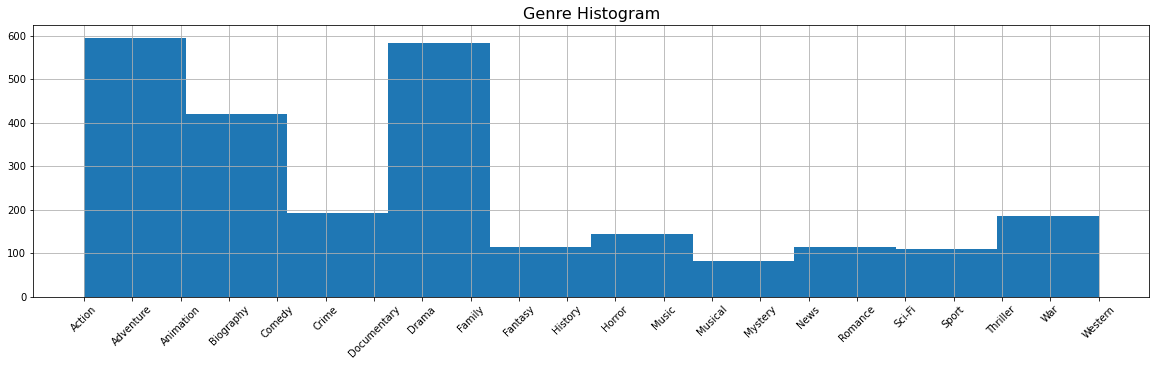

In [70]:
ax = split_rawdf['genres'].sort_values().hist(figsize=(20,5), xrot=45)
ax.set_title('Genre Histogram', fontsize=16);

# Most  movies by genre
There are mostly action and adventure movies within the past 10 years.


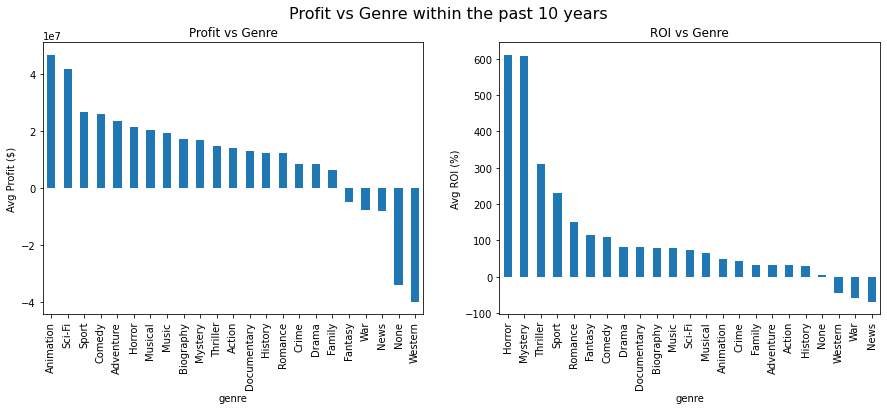

In [92]:
# Bar charts showing profit vs genre
fig, (ax1, ax2) = plt.subplots(1,2)
df.sort_values('avg_profit', inplace=True, ascending=False)
df.plot.bar(x='genre', y='avg_profit', ax=ax1, figsize=(15,5));
df.sort_values('roi', inplace=True, ascending=False)
df.plot.bar(x='genre', y='roi', ax=ax2)
ax1.set_title('Profit vs Genre')
ax2.set_title('ROI vs Genre')
ax1.set_ylabel('Avg Profit ($)')
ax2.set_ylabel('Avg ROI (%)')
ax1.get_legend().remove()
ax2.get_legend().remove()

fig.suptitle('Profit vs Genre within the past 10 years',fontsize=16);

  ## Profit by genre
  Best profit: Animation, sci-fi
  
  Best multiplier of budget: Horror, mystery

In [93]:
# Actors
q = '''
SELECT kr.movie_id, kr.person_id, persons.*
FROM persons
JOIN known_for AS kr ON kr.person_id = persons.person_id
JOIN principals AS pr ON pr.person_id = kr.person_id
WHERE category = "actor" 
AND primary_profession LIKE "%actor%"
AND death_year is NULL
AND birth_year > 1980
'''

actorsdf = pd.read_sql(q, conn)
actorsdf.head()

actorprofitq = """
SELECT AVG(profit) AS avg_profit, AVG(roi) AS avg_roi, *
FROM actorsdf 
JOIN rawdf ON actorsdf.movie_id = rawdf.movie_id
GROUP BY person_id, primary_name
ORDER BY avg_profit DESC
"""

actors_profit_df = pysqldf(actorprofitq)
actors_profit_df.head()


,avg_profit,avg_roi,movie_id,person_id,primary_name,birth_year,death_year,primary_profession,profit,roi,genres,movie_id,title
0,500059566.0,250.029783,tt1825683,nm1091701,Denzel Whitaker,1990.0,None,"actor,art_department,editorial_department",500059566.0,250.029783,"Action,Adventure,Sci-Fi",tt1825683,Black Panther
1,437270625.0,203.381686,tt0369610,nm1781213,Matty Cardarople,1983.0,None,"actor,miscellaneous,director",437270625.0,203.381686,"Action,Adventure,Sci-Fi",tt0369610,Jurassic World
2,378815482.0,126.271827,tt4154756,nm2739851,Ross Marquand,1981.0,None,"actor,producer,miscellaneous",378815482.0,126.271827,"Action,Adventure,Sci-Fi",tt4154756,Avengers: Infinity War
3,378815482.0,126.271827,tt4154756,nm4367623,Kevin D Wilson,1990.0,None,"editor,sound_department,actor",378815482.0,126.271827,"Action,Adventure,Sci-Fi",tt4154756,Avengers: Infinity War
4,332177324.0,166.088662,tt3748528,nm4095121,Russell Balogh,1981.0,None,"stunts,actor",332177324.0,166.088662,"Action,Adventure,Sci-Fi",tt3748528,Rogue One: A Star Wars Story


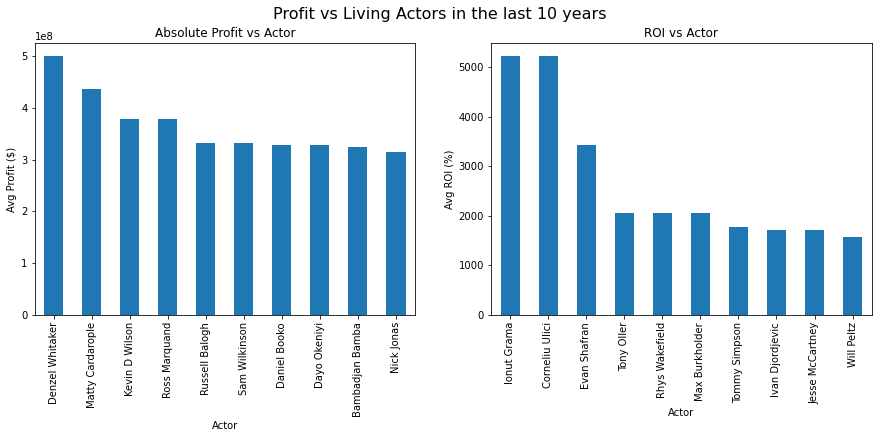

In [99]:
# Bar charts showing profit vs actor
fig, (actorax1, actorax2) = plt.subplots(1,2)

actors_profit_df.sort_values('avg_profit', inplace=True, ascending=False)
actors_profit_df[0:10].plot.bar(x='primary_name', y='avg_profit', ax=actorax1, figsize=(15,5));

# Sort by ROI
actors_profit_df.sort_values('avg_roi', inplace=True, ascending=False)

actors_profit_df[0:10].plot.bar(x='primary_name', y='avg_roi', ax=actorax2)

actorax1.set_title('Absolute Profit vs Actor')
actorax2.set_title('ROI vs Actor')
actorax1.set_xlabel('Actor')
actorax2.set_xlabel('Actor')
actorax1.set_ylabel('Avg Profit ($)')
actorax2.set_ylabel('Avg ROI (%)')
actorax1.get_legend().remove()
actorax2.get_legend().remove()

fig.suptitle('Profit vs Living Actors in the last 10 years', fontsize=16);


## Actor conclusions
Best absolute profit: Denzel Whitaker, Matty Cardarople

Best ROI: Ionut Grama, Corneliu Ulici

In [95]:
# Writers
q = '''
SELECT w.movie_id, p.*
FROM persons AS p
JOIN writers AS w ON w.person_id = p.person_id
WHERE death_year is NULL AND birth_year > 1980
'''

writers_df = pd.read_sql(q, conn)
writers_df.head()

writerprofitq = """
SELECT AVG(profit) AS avg_profit, AVG(roi) AS avg_roi, *
FROM writers_df AS w
JOIN rawdf ON w.movie_id = rawdf.movie_id
GROUP BY person_id, primary_name
ORDER BY avg_profit DESC
"""
writers_profit_df = pysqldf(writerprofitq)
writers_profit_df.head()

,avg_profit,avg_roi,movie_id,person_id,primary_name,birth_year,death_year,primary_profession,profit,roi,genres,movie_id,title
0,181461711.0,103.692406,tt2096673,nm2919995,Simon Rich,1984.0,None,"writer,producer,actor",181461711.0,103.692406,"Adventure,Animation,Comedy",tt2096673,Inside Out
1,171024361.0,1006.025653,tt6644200,nm1399714,Scott Beck,1984.0,None,"writer,producer,director",171024361.0,1006.025653,"Drama,Horror,Sci-Fi",tt6644200,A Quiet Place
2,171024361.0,1006.025653,tt6644200,nm1456816,Bryan Woods,1984.0,None,"writer,producer,director",171024361.0,1006.025653,"Drama,Horror,Sci-Fi",tt6644200,A Quiet Place
3,164092705.0,149.175186,tt1454468,nm0190861,Jonás Cuarón,1981.0,None,"writer,producer,director",164092705.0,149.175186,"Drama,Sci-Fi,Thriller",tt1454468,Gravity
4,163435508.5,566.727064,tt1825683,nm3363032,Ryan Coogler,1986.0,None,"director,writer,producer",500059566.0,250.029783,"Action,Adventure,Sci-Fi",tt1825683,Black Panther


In [96]:
writers_profit_df.sort_values('avg_profit', inplace=True, ascending=False)

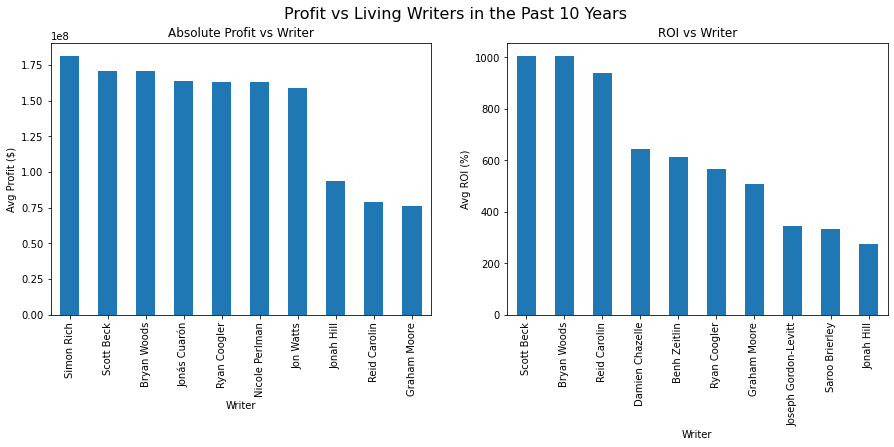

In [101]:
# Bar charts showing profit vs writer
fig, (writerax1, writerax2) = plt.subplots(1,2)
writers_profit_df.sort_values('avg_profit', inplace=True, ascending=False)
writers_profit_df[0:10].plot.bar(x='primary_name', y='avg_profit', ax=writerax1, figsize=(15,5));

# Sort by ROI
writers_profit_df.sort_values('avg_roi', inplace=True, ascending=False)

writers_profit_df[0:10].plot.bar(x='primary_name', y='avg_roi', ax=writerax2)
writerax1.set_title('Absolute Profit vs Writer')
writerax2.set_title('ROI vs Writer')
writerax1.set_xlabel('Writer')
writerax2.set_xlabel('Writer')
writerax1.set_ylabel('Avg Profit ($)')
writerax2.set_ylabel('Avg ROI (%)')
writerax1.get_legend().remove()
writerax2.get_legend().remove()
fig.suptitle("Profit vs Living Writers in the Past 10 Years", fontsize=16);

## Writer Conclusions
Simon Rich writes the best movies based on absolute profit.

Scott Beck writes the best movies based on ROI.

## Final Conclusion
Create a horror/mystery written by Scott Beck with actors Ionut Grama, Corneliu Ulici.